# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Dependencies: 
PyTorch, matplotlib, numpy, opencv-python

## Implementation Note

I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Setup

In [1]:
import cv2
import os
import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np

# plots setup
import matplotlib.pyplot as plt
plt_interval = 50

root = './mnist_data'
if not os.path.exists(root):
    os.mkdir(root)
    
# if not exist, download mnist dataset
trans = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5,), (1.0,))])
trainset = dset.MNIST(root=root, train=True, transform=trans, download=True)
testset = dset.MNIST(root=root, train=False, transform=trans, download=True)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('0', 'high', 'low')

# create binary dataset 
label1 = [0,1,2,3,4]; label2 = [5,6,7,8,9] # change if desired
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)

# adjust train set
# mask = (trainset.train_labels == label1) | (trainset.train_labels == label2)
# trainset.train_data=torch.from_numpy(trainset.train_data.numpy()[mask])
# trainset.train_labels=trainset.train_labels[mask]
mask1 = (trainset.train_labels == 0) | (trainset.train_labels == 1) | (trainset.train_labels == 2) | (trainset.train_labels == 3) | (trainset.train_labels == 4)
mask2 = (trainset.train_labels == 5) | (trainset.train_labels == 6) | (trainset.train_labels == 7) | (trainset.train_labels == 8) | (trainset.train_labels == 9)
trainset.train_labels[mask1] = -1
trainset.train_labels[mask2] = 1

# adjust test set
# mask = (testset.test_labels == label1) | (testset.test_labels == label2)
# testset.test_data=torch.from_numpy(testset.test_data.numpy()[mask])
# testset.test_labels=testset.test_labels[mask]
mask1 = (testset.test_labels == 0) | (testset.test_labels == 1) | (testset.test_labels == 2) | (testset.test_labels == 3) | (testset.test_labels == 4)
mask2 = (testset.test_labels == 5) | (testset.test_labels == 6) | (testset.test_labels == 7) | (testset.test_labels == 8) | (testset.test_labels == 9)
testset.test_labels[mask1] = -1
testset.test_labels[mask2] = 1

# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("Data loaded:")
print("- Training set size:", len(trainset))
print("  Dimensions of train images:", np.shape(trainset.train_data))
print("- Test set size:", len(testset))
print("  Dimensions of test images:", np.shape(testset.test_data))

w_size = np.shape(trainset.train_data)[1] * np.shape(trainset.train_data)[2]
print("\nVector dimensionality:", w_size)

Data loaded:
- Training set size: 60000
  Dimensions of train images: torch.Size([60000, 28, 28])
- Test set size: 10000
  Dimensions of test images: torch.Size([10000, 28, 28])

Vector dimensionality: 784


Test Images:


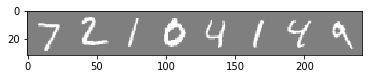

 high   low   low   low   low   low   low  high
Train Images:


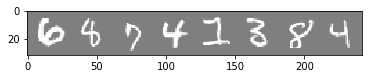

 high  high  high   low   low   low  high   low


Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dqi/.conda/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/queues.py", line 33

In [2]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random test images
dataiter = iter(testloader)
images = []; labels = []
img_count = 8
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Test Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# get some random train images
dataiter = iter(trainloader)
images = []; labels = []
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Train Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# Weak Learner: Perceptron

In [3]:
# set learning rate
eta = 0.01

# get output of weak learner i
# o.w. get output of combination of WLs    
# returns label in {-1, +1}
def predict_WL(weak_learners, x, i=0):
    predict = np.dot(x, weak_learners[i])
    return -1 if (np.sign(predict) < 0) else 1

# update weak learner i
# accepts y in {-1, 1}
def update_WL(weak_learners, x, y, i):
    predict = predict_WL(weak_learners, x, i)
    if (predict*y) < 0:
        weak_learners[i] = weak_learners[i] + eta * x * y
    return weak_learners
    
# get output of combination of WLs (unweighted)
# returns label in {-1, +1}
def predict_WL_alg1(weak_learners, x):    
    N = len(weak_learners)
    prediction = 0
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return -1 if (np.sign(prediction) < 0) else 1

# get output of combination of WLs (weighted)
# returns label in {-1, +1}
def predict_WL_alg2(weak_learners, x, alpha, i):
    prediction = 0
    for j in range(0, i+1):
        prediction += alpha[j] * predict_WL(weak_learners, x, j)
    return -1 if (np.sign(prediction) < 0) else 1

# Baseline - Weak Learner

In [4]:
def baseline(weak_learner, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # training
    for t, data in enumerate(trainloader, 1):   
        # perform T iterations
        if t > T: break
        
        # optimization step
        x, y = data
        x = x.numpy().flatten()
        predict = -1 if (np.sign(np.dot(x, weak_learner)) < 0) else 1 
        if (predict*y) < 0:
            weak_learner = weak_learner + eta * x * y
        
        n_mistakes += (predict != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
    
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
    
    return np.array(n_mistakes_over_time), weak_learner

# Online BBM 

In [5]:
# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

def onlineBBM(weak_learners, T, gamma):

    # keep track of metrics every 100 iterations
    n_mistakes = 0 
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    max_w = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)        
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            prediction = predict_WL(weak_learners, x, j-1)
            s[j] = s[j-1] + y * prediction
            k[j] = np.floor((N - j - s[j-1] + 1)/2)
            binom_term = 0 if (k[j] < 0 or k[j] > N - j) else binom(N-j, k[j])
            w[j] = binom_term * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N - j - k[j])
            max_w[j] = max(w[j], max_w[j]) 
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability  
            prob = 1 if max_w[j] == 0 else w[j]/max_w[j]
            if np.random.random_sample() < prob:
                update_WL(weak_learners, x, y, j-1)
                
        # evaluate mistakes
        n_mistakes += (y_hat != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
        
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
    print("Smallest gamma:", np.min(0.5 - n_mistakes_WL / T))
                
    return n_mistakes_over_time, weak_learners

# AdaBoost OL

In [6]:
def adaboostOL(weak_learners, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)    
    v = np.ones(N)
    alpha = np.zeros(N)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y wrt each WL
        prediction = 0
        for j in range(N):            
            prediction += alpha[j] * predict_WL(weak_learners, x, j)
            y_hat[j] = -1 if (np.sign(prediction) < 0) else 1
            
        # model randomly chooses prediction of some WL
        v = v / np.sum(v)
        idx = np.random.choice(N, size=1, p=v)
        y_hat_final = y_hat[idx]
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            prediction = predict_WL(weak_learners, x, j-1)
            z[j] = y * prediction
            s[j] = s[j-1] + alpha[j-1] * z[j]
            alpha[j-1] = max(-2, min(2, alpha[j-1] + (4 * z[j] / np.sqrt(t)) / (1 + np.exp(s[j]))))
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < 1 / (1 + np.exp(s[j-1])):
                update_WL(weak_learners, x, y, j-1)
                
            # update v
            indic = -1 if (y_hat_final != y) else 0
            v[j-1] = v[j-1] * np.exp(indic)
            
        # evaluate mistakes
        n_mistakes += (y_hat_final != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
       
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
    print("Smallest gamma:", np.min(0.5 - n_mistakes_WL / T))
    
    return n_mistakes_over_time, alpha

## Evaluate Models on Test Set

In [7]:
def evaluate_WLs(weak_learners):
    print("EVALUATING WEAK LEARNERS")
    
    for i in range(len(weak_learners)):
        correct = 0
        for data in testloader:
            x, y = data
            x = x.numpy().flatten()
            prediction = predict_WL(weak_learners, x, i)
            correct += (prediction == y).sum()
        print('Accuracy of weak learner', i, 'on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
        
def evaluate_model_onlineBBM(weak_learners):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    for data in testloader: 
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg1(weak_learners, x)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
    
def evaluate_model_adaboostOL(weak_learners, alpha):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    total = 0
    for data in testloader:
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg2(weak_learners, x, alpha, N-1)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))

## Evaluate Models Online

In [8]:
def plot_loss(T, mistakes):
    error_rates = mistakes/ np.arange(plt_interval, T+1, plt_interval)
    plt.plot(np.arange(2*plt_interval, T+1, plt_interval), error_rates[1:])
    plt.title("Fraction of mistakes made online by the strong online learner")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()

def evaluate_baseline(T):
    print("\033[1mEvaluating Baseline:\n\033[0m")
    
    weak_learner = np.zeros(784)
    mistakes, weak_learner = baseline(weak_learner, T)
    evaluate_WLs([weak_learner])
    
    plot_loss(T, mistakes)
    
def evaluate_onlineBBM(N, T, gamma):
    print("\033[1mEvaluating Online BBM:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(784)) 
    
    # test
    mistakes, weak_learners = onlineBBM(weak_learners, T, gamma)
    print()
#     evaluate_WLs(weak_learners)
#     print()
    evaluate_model_onlineBBM(weak_learners)
    
    plot_loss(T, mistakes)
    
def evaluate_adaboostOL(N, T, gamma):
    print("\033[1mEvaluating AdaBoost OL:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(784)) 
        
    mistakes, alpha = adaboostOL(weak_learners, T)
#     print()
#     evaluate_WLs(weak_learners)
    print()
    evaluate_model_adaboostOL(weak_learners, alpha)
    
    plot_loss(T, mistakes)

## Baseline

Evaluating Baseline:

Fraction of mistakes after 10000 iterations: 0.2401
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 82 %


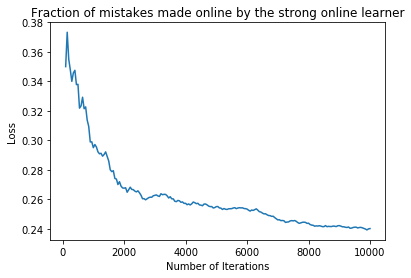

In [9]:
evaluate_baseline(T=10000) 

Evaluating Baseline:

Fraction of mistakes after 2500 iterations: 0.2608
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 80 %


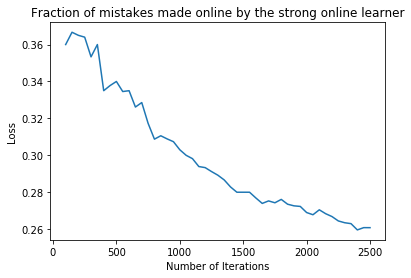

In [10]:
evaluate_baseline(T=2500) 

Evaluating Baseline:

Fraction of mistakes after 5000 iterations: 0.2496
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 69 %


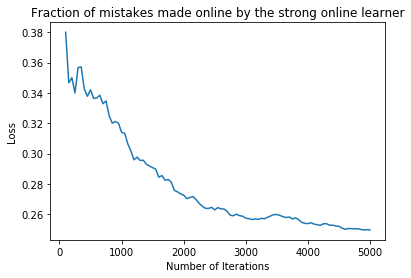

In [11]:
evaluate_baseline(T=5000) 

Evaluating Baseline:

Fraction of mistakes after 20000 iterations: 0.22645
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 80 %


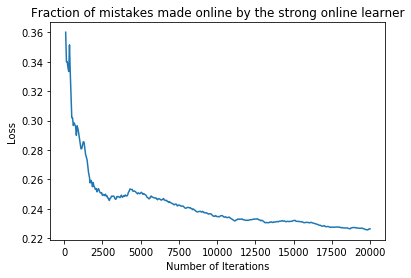

In [12]:
evaluate_baseline(T=20000) 

## Run Experiments

In [9]:
def run_experiment(T=10000, N=10, model="bbm", gamma=0.2):
    evaluate = dict(bbm=evaluate_onlineBBM, adaboost=evaluate_adaboostOL)
    evaluate[model](N, T, gamma)

In [ ]:
run_experiment(T=20000, N=5, model="adaboost", gamma=0.5)

# Online BBM Experiments:

# Different number of weak learners N

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.282
Fraction of mistakes by time 2000 0.25
Fraction of mistakes by time 3000 0.24133333333333334
Fraction of mistakes by time 4000 0.2335
Fraction of mistakes by time 5000 0.221
Fraction of mistakes by time 6000 0.21683333333333332
Fraction of mistakes by time 7000 0.21457142857142858
Fraction of mistakes by time 8000 0.213625
Fraction of mistakes by time 9000 0.21444444444444444
Fraction of mistakes by time 10000 0.2109
Fraction of mistakes after 10000 iterations: 0.2109
Edges of weak learners:
 [0.2633 0.2634 0.2791 0.2575]
Smallest gamma: 0.2575


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 83 %


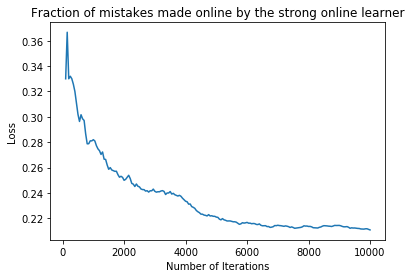

In [34]:
run_experiment(T=10000, N=4, model="bbm", gamma=0.25)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.271
Fraction of mistakes by time 2000 0.255
Fraction of mistakes by time 3000 0.25166666666666665
Fraction of mistakes by time 4000 0.24725
Fraction of mistakes by time 5000 0.2346
Fraction of mistakes by time 6000 0.22983333333333333
Fraction of mistakes by time 7000 0.22528571428571428
Fraction of mistakes by time 8000 0.218375
Fraction of mistakes by time 9000 0.2157777777777778
Fraction of mistakes by time 10000 0.2113
Fraction of mistakes after 10000 iterations: 0.2113
Edges of weak learners:
 [0.2613 0.2613 0.2613 0.2646 0.2755 0.2295 0.2296 0.1987]
Smallest gamma: 0.1987


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 82 %


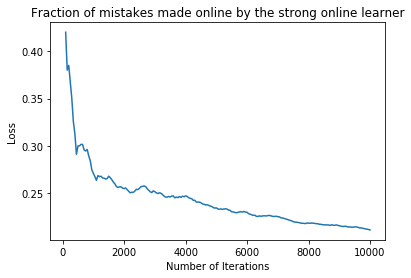

In [35]:
run_experiment(T=10000, N=8, model="bbm", gamma=0.18)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.306
Fraction of mistakes by time 2000 0.276
Fraction of mistakes by time 3000 0.257
Fraction of mistakes by time 4000 0.2505
Fraction of mistakes by time 5000 0.2418
Fraction of mistakes by time 6000 0.24066666666666667
Fraction of mistakes by time 7000 0.23685714285714285
Fraction of mistakes by time 8000 0.232875
Fraction of mistakes by time 9000 0.22922222222222222
Fraction of mistakes by time 10000 0.2261
Fraction of mistakes after 10000 iterations: 0.2261
Edges of weak learners:
 [0.2693 0.2693 0.2693 0.2693 0.2693 0.2693 0.2693 0.2693 0.2963 0.2502
 0.2228 0.1914 0.1692 0.1841 0.1832 0.1622]
Smallest gamma: 0.1622


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 82 %


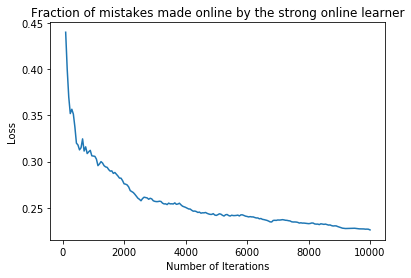

In [36]:
run_experiment(T=10000, N=16, model="bbm", gamma=0.15)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.275
Fraction of mistakes by time 2000 0.265
Fraction of mistakes by time 3000 0.26266666666666666
Fraction of mistakes by time 4000 0.25975
Fraction of mistakes by time 5000 0.2544
Fraction of mistakes by time 6000 0.24766666666666667
Fraction of mistakes by time 7000 0.24385714285714286
Fraction of mistakes by time 8000 0.243625
Fraction of mistakes by time 9000 0.24144444444444443
Fraction of mistakes by time 10000 0.2388
Fraction of mistakes after 10000 iterations: 0.2388
Edges of weak learners:
 [0.2586 0.2586 0.2586 0.2586 0.2586 0.2586 0.2586 0.2586 0.2586 0.2586
 0.2586 0.2586 0.2586 0.2586 0.2586 0.2586 0.2974 0.2538 0.2086 0.2156
 0.1948 0.1977 0.1803 0.208  0.1956 0.2226 0.2253 0.246  0.2645 0.2585
 0.2327 0.2667]
Smallest gamma: 0.18030000000000002


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 77 %


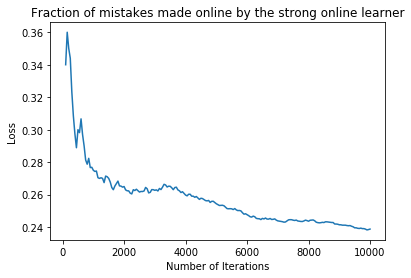

In [37]:
run_experiment(T=10000, N=32, model="bbm", gamma=0.16)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.309
Fraction of mistakes by time 2000 0.268
Fraction of mistakes by time 3000 0.254
Fraction of mistakes by time 4000 0.24875
Fraction of mistakes by time 5000 0.2474
Fraction of mistakes by time 6000 0.24316666666666667
Fraction of mistakes by time 7000 0.23942857142857144
Fraction of mistakes by time 8000 0.239125
Fraction of mistakes by time 9000 0.23933333333333334
Fraction of mistakes by time 10000 0.2379
Fraction of mistakes after 10000 iterations: 0.2379
Edges of weak learners:
 [0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621
 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621
 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621 0.2621
 0.2621 0.2621 0.2895 0.2476 0.2109 0.2064 0.1749 0.1613 0.1546 0.1654
 0.1654 0.2004 0.2173 0.1861 0.2161 0.1883 0.2319 0.2025 0.2143 0.2411
 0.2539 0.2656 0.2593 0.2574 0.2269 0.2429 0.2491 0.2606 0.2603 0.2621
 0.2621 0.2621 0.2621 0

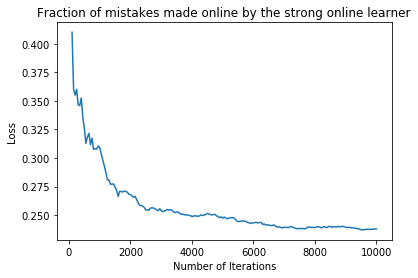

In [38]:
run_experiment(T=10000, N=64, model="bbm", gamma=0.14)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.295
Fraction of mistakes by time 2000 0.272
Fraction of mistakes by time 3000 0.265
Fraction of mistakes by time 4000 0.25725
Fraction of mistakes by time 5000 0.2492
Fraction of mistakes by time 6000 0.244
Fraction of mistakes by time 7000 0.24314285714285713
Fraction of mistakes by time 8000 0.24475
Fraction of mistakes by time 9000 0.244
Fraction of mistakes by time 10000 0.2446
Fraction of mistakes after 10000 iterations: 0.2446
Edges of weak learners:
 [0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2554 0.2554 0.2554 0.2823 0.2524 0.207  0.

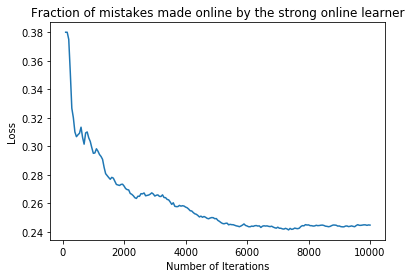

In [11]:
run_experiment(T=10000, N=128, model="bbm", gamma=0.11)

# Different number of iterations T

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.271
Fraction of mistakes by time 2000 0.243
Fraction of mistakes after 2500 iterations: 0.2428
Edges of weak learners:
 [0.2328 0.2328 0.2328 0.2328 0.2328 0.2368 0.2092 0.212  0.1776 0.1748
 0.1528 0.1828 0.1668 0.2012 0.1388 0.1256]
Smallest gamma: 0.1256


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 81 %


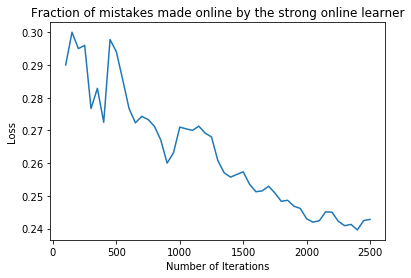

In [42]:
run_experiment(T=2500, N=16, model="bbm", gamma=0.09)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.319
Fraction of mistakes by time 2000 0.2845
Fraction of mistakes by time 3000 0.25366666666666665
Fraction of mistakes by time 4000 0.2425
Fraction of mistakes by time 5000 0.233
Fraction of mistakes after 5000 iterations: 0.233
Edges of weak learners:
 [0.2472 0.2472 0.2472 0.2472 0.2472 0.2472 0.2492 0.2434 0.2254 0.1686
 0.1352 0.1692 0.1796 0.1472 0.1638 0.1934]
Smallest gamma: 0.1352


EVALUATING MODEL


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2ad0c8af20b8>>
Traceback (most recent call last):
  File "/home/dqi/.conda/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/dqi/.conda/envs/py36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/reduction.py", line 182, in 

Accuracy of the network on the 2000 test images: 79 %


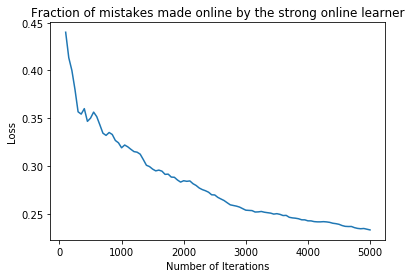

In [45]:
run_experiment(T=5000, N=16, model="bbm", gamma=0.1)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.288
Fraction of mistakes by time 2000 0.2605
Fraction of mistakes by time 3000 0.23833333333333334
Fraction of mistakes by time 4000 0.23275
Fraction of mistakes by time 5000 0.2252
Fraction of mistakes by time 6000 0.22233333333333333
Fraction of mistakes by time 7000 0.21914285714285714
Fraction of mistakes by time 8000 0.217125
Fraction of mistakes by time 9000 0.21622222222222223
Fraction of mistakes by time 10000 0.2147
Fraction of mistakes by time 11000 0.21309090909090908
Fraction of mistakes by time 12000 0.21058333333333334
Fraction of mistakes by time 13000 0.2133076923076923
Fraction of mistakes by time 14000 0.21157142857142858
Fraction of mistakes by time 15000 0.21133333333333335
Fraction of mistakes by time 16000 0.2106875
Fraction of mistakes by time 17000 0.20876470588235294
Fraction of mistakes by time 18000 0.20733333333333334
Fraction of mistakes by time 19000 0.20489473684210527
Fraction of mistakes by tim

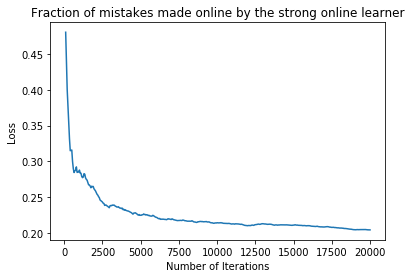

In [ ]:
run_experiment(T=20000, N=16, model="bbm", gamma=0.11)

# Online BBM Experiments:

# Different number of weak learners N

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.3
Fraction of mistakes by time 2000 0.2635
Fraction of mistakes by time 3000 0.2633333333333333
Fraction of mistakes by time 4000 0.25975
Fraction of mistakes by time 5000 0.2568
Fraction of mistakes by time 6000 0.25483333333333336
Fraction of mistakes by time 7000 0.251
Fraction of mistakes by time 8000 0.25
Fraction of mistakes by time 9000 0.25177777777777777
Fraction of mistakes by time 10000 0.2482
Fraction of mistakes after 10000 iterations: 0.2482
Edges of weak learners:
 [0.2491 0.2095 0.1974 0.1856]
Smallest gamma: 0.1856


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 76 %


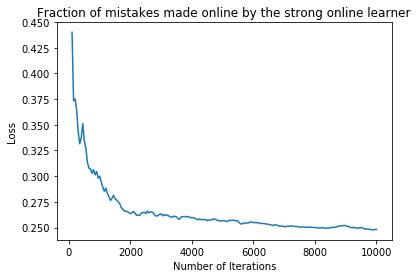

In [24]:
run_experiment(T=10000, N=4, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.302
Fraction of mistakes by time 2000 0.2775
Fraction of mistakes by time 3000 0.272
Fraction of mistakes by time 4000 0.26975
Fraction of mistakes by time 5000 0.261
Fraction of mistakes by time 6000 0.2615
Fraction of mistakes by time 7000 0.25771428571428573
Fraction of mistakes by time 8000 0.25625
Fraction of mistakes by time 9000 0.258
Fraction of mistakes by time 10000 0.2541
Fraction of mistakes after 10000 iterations: 0.2541
Edges of weak learners:
 [0.2387 0.2099 0.186  0.1991 0.1863 0.181  0.1729 0.1784]
Smallest gamma: 0.1729


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 70 %


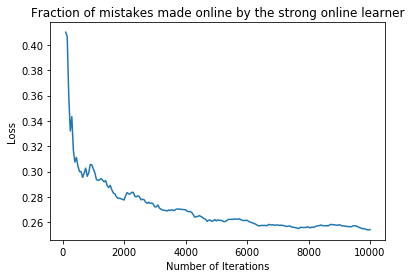

In [25]:
run_experiment(T=10000, N=8, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.339
Fraction of mistakes by time 2000 0.3
Fraction of mistakes by time 3000 0.283
Fraction of mistakes by time 4000 0.27825
Fraction of mistakes by time 5000 0.2696
Fraction of mistakes by time 6000 0.26166666666666666
Fraction of mistakes by time 7000 0.25957142857142856
Fraction of mistakes by time 8000 0.256875
Fraction of mistakes by time 9000 0.25
Fraction of mistakes by time 10000 0.2467
Fraction of mistakes after 10000 iterations: 0.2467
Edges of weak learners:
 [0.2511 0.2182 0.1919 0.1845 0.1839 0.1779 0.1878 0.1791 0.1732 0.172
 0.189  0.1811 0.1695 0.1828 0.1788 0.1799]
Smallest gamma: 0.16949999999999998


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 76 %


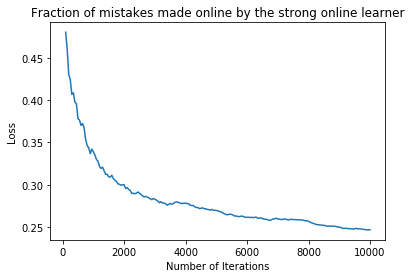

In [26]:
run_experiment(T=10000, N=16, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.362
Fraction of mistakes by time 2000 0.3215
Fraction of mistakes by time 3000 0.29233333333333333
Fraction of mistakes by time 4000 0.27625
Fraction of mistakes by time 5000 0.2664
Fraction of mistakes by time 6000 0.2648333333333333
Fraction of mistakes by time 7000 0.261
Fraction of mistakes by time 8000 0.255875
Fraction of mistakes by time 9000 0.25
Fraction of mistakes by time 10000 0.2467
Fraction of mistakes after 10000 iterations: 0.2467
Edges of weak learners:
 [0.2523 0.2141 0.2017 0.1906 0.1791 0.196  0.1881 0.1984 0.1975 0.1953
 0.2    0.1834 0.1904 0.1916 0.1804 0.1913 0.1912 0.189  0.1962 0.1902
 0.1817 0.1891 0.1841 0.2048 0.1814 0.1914 0.191  0.184  0.1926 0.178
 0.1917 0.189 ]
Smallest gamma: 0.178


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 74 %


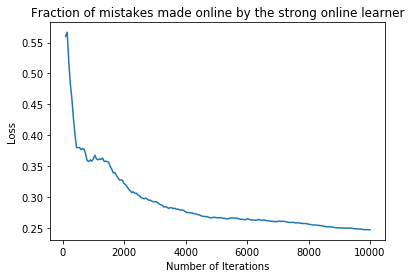

In [27]:
run_experiment(T=10000, N=32, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.323
Fraction of mistakes by time 2000 0.2965
Fraction of mistakes by time 3000 0.2876666666666667
Fraction of mistakes by time 4000 0.275
Fraction of mistakes by time 5000 0.2636
Fraction of mistakes by time 6000 0.25933333333333336
Fraction of mistakes by time 7000 0.25771428571428573
Fraction of mistakes by time 8000 0.258375
Fraction of mistakes by time 9000 0.25355555555555553
Fraction of mistakes by time 10000 0.2515
Fraction of mistakes after 10000 iterations: 0.2515
Edges of weak learners:
 [0.2548 0.2114 0.202  0.1821 0.1975 0.186  0.1918 0.1891 0.1824 0.2028
 0.1875 0.1884 0.1773 0.1897 0.1913 0.1988 0.1835 0.1895 0.182  0.1843
 0.1982 0.1836 0.1783 0.1731 0.1865 0.182  0.1942 0.1864 0.1856 0.1859
 0.1865 0.1766 0.184  0.1885 0.1903 0.1957 0.1803 0.1869 0.1947 0.1847
 0.1864 0.1883 0.1793 0.1884 0.191  0.1955 0.1796 0.1814 0.1839 0.1842
 0.197  0.1774 0.1816 0.1826 0.1916 0.1791 0.1812 0.1884 0.1839 0.1869
 0.1844 0.

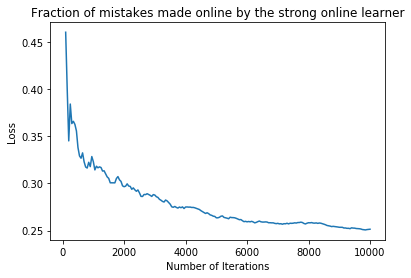

In [28]:
run_experiment(T=10000, N=64, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.346
Fraction of mistakes by time 2000 0.303
Fraction of mistakes by time 3000 0.295
Fraction of mistakes by time 4000 0.2875
Fraction of mistakes by time 5000 0.2782
Fraction of mistakes by time 6000 0.2725
Fraction of mistakes by time 7000 0.2672857142857143
Fraction of mistakes by time 8000 0.265875
Fraction of mistakes by time 9000 0.2683333333333333
Fraction of mistakes by time 10000 0.2649
Fraction of mistakes after 10000 iterations: 0.2649
Edges of weak learners:
 [0.2597 0.2178 0.1942 0.1944 0.1996 0.1839 0.1852 0.1875 0.1917 0.1886
 0.1947 0.1901 0.1851 0.1892 0.1898 0.1889 0.1878 0.1971 0.1863 0.1832
 0.1927 0.1976 0.1864 0.1915 0.1999 0.1864 0.1953 0.1789 0.1894 0.1947
 0.2092 0.1966 0.1813 0.194  0.1834 0.1882 0.1895 0.1906 0.1956 0.1963
 0.1874 0.2052 0.1937 0.1909 0.1931 0.2048 0.1983 0.1927 0.1912 0.1964
 0.1891 0.1902 0.1907 0.1909 0.1915 0.1876 0.1988 0.1967 0.1872 0.1948
 0.1903 0.1884 0.1988 0.1895 0.1975 0.

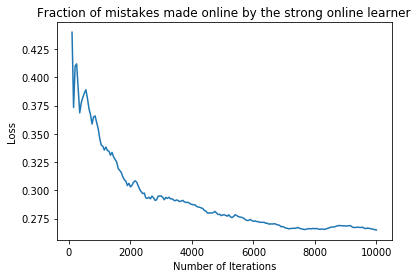

In [29]:
run_experiment(T=10000, N=128, model="adaboost")

# Different number of iterations T

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.318
Fraction of mistakes by time 2000 0.2895
Fraction of mistakes after 2500 iterations: 0.2848
Edges of weak learners:
 [0.2016 0.2072 0.2036 0.1624 0.1468 0.1692 0.1724 0.1616]
Smallest gamma: 0.14679999999999999


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 74 %


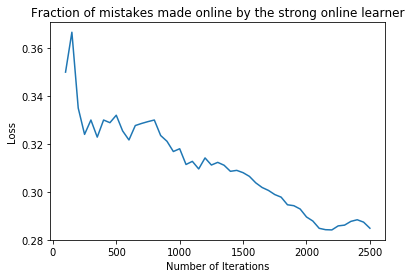

In [30]:
run_experiment(T=2500, N=8, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.292
Fraction of mistakes by time 2000 0.2725
Fraction of mistakes by time 3000 0.25866666666666666
Fraction of mistakes by time 4000 0.25875
Fraction of mistakes by time 5000 0.2508
Fraction of mistakes after 5000 iterations: 0.2508
Edges of weak learners:
 [0.2456 0.1938 0.192  0.1706 0.1816 0.1744 0.1702 0.182 ]
Smallest gamma: 0.17020000000000002


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 60 %


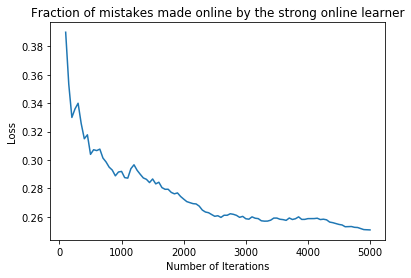

In [31]:
run_experiment(T=5000, N=8, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.312
Fraction of mistakes by time 2000 0.2795
Fraction of mistakes by time 3000 0.2763333333333333
Fraction of mistakes by time 4000 0.2715
Fraction of mistakes by time 5000 0.264
Fraction of mistakes by time 6000 0.25516666666666665
Fraction of mistakes by time 7000 0.2542857142857143
Fraction of mistakes by time 8000 0.248875
Fraction of mistakes by time 9000 0.24588888888888888
Fraction of mistakes by time 10000 0.2434
Fraction of mistakes by time 11000 0.24527272727272728
Fraction of mistakes by time 12000 0.24125
Fraction of mistakes by time 13000 0.24107692307692308
Fraction of mistakes by time 14000 0.23835714285714285
Fraction of mistakes by time 15000 0.2372
Fraction of mistakes by time 16000 0.2358125
Fraction of mistakes by time 17000 0.2341764705882353
Fraction of mistakes by time 18000 0.23427777777777778
Fraction of mistakes by time 19000 0.23336842105263159
Fraction of mistakes by time 20000 0.23185
Fraction of 

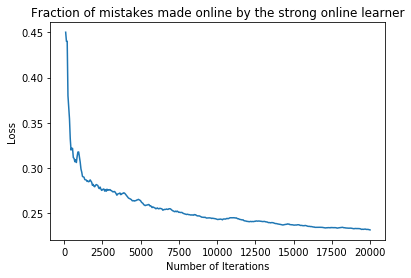

In [32]:
run_experiment(T=20000, N=8, model="adaboost")

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf